In [1]:
"""
@Author: yangwenhao
@Contact: 874681044@qq.com
@Software: PyCharm
@File: input_compare.py
@Time: 2020/3/25 5:30 PM
@Overview:
"""
import argparse
import pathlib
import pickle
import random
import json

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from python_speech_features import mel2hz
from scipy import interpolate

%matplotlib inline

In [39]:
# args = {}

# extract_path='/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_50_var_50/epoch_50'
cam_method = 'fullgrad'
extract_path='/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_61_var_%s/epoch_61' % cam_method

# Training options
feat_dim = 161
samples = 3000
acoustic_feature = 'spectrogram' # choices=['fbank', 'spectrogram', 'mfcc'],
seed = 123456
load_from_pickle = False # load saved gradient and data 

random.seed(seed)
np.random.seed(seed)

In [47]:
uid2spk = {}
with open('/home/work2020/yangwenhao/project/lstm_speaker_verification/data/vox2/dev/utt2spk', 'r') as f:
    for l in f.readlines():
        uid, sid = l.split()
        if uid in some_data:
            uid2spk[uid] = sid
    
sid2gender = {}
with open('/home/work2020/yangwenhao/project/lstm_speaker_verification/data/vox2/dev/spk2gender', 'r') as f:
    for l in f.readlines():
        sid, gender = l.split()
        sid2gender[sid] = gender
        
uid2gender = {}
for uid in uid2spk:
    this_sid = uid2spk[uid]
    
    uid2gender[uid] = sid2gender[this_sid] if this_sid in sid2gender else 'null'

In [40]:
# subsets = ['orignal', 'babble', 'noise', 'music', 'reverb']

# load selected input uids
dir_path = pathlib.Path(extract_path)
print('Path is %s' % str(dir_path))

# inputs [train/valid/test]
if load_from_pickle:
    with open(extract_path + '/freq.data.pickle', 'rb') as f:
        freq_data = pickle.load(f)  # avg on time axis
    with open(extract_path + '/time.data.pickle', 'rb') as f:
        time_data = pickle.load(f)  # avg on freq axis

else:
    train_lst = list(dir_path.glob('*train*bin'))
    train_id_lst = list(dir_path.glob('*train*json'))
    veri_lst = list(dir_path.glob('*ver*bin'))
    valid_lst = list(dir_path.glob('*valid*bin'))
    test_lst = list(dir_path.glob('*test*bin'))

    print(' Train set extracting:')
    time_data = []
    num_utt = 0
    for t in train_lst:
        p = str(t)
        with open(p, 'rb') as f:
            sets = pickle.load(f)
            for (data, grad) in sets:
                time_data.append((data, grad))
                num_utt += 1
                if num_utt >= samples:
                    break
    
    with open(extract_path + '/data_grad.pickle', 'wb') as f:
        pickle.dump(time_data, f, protocol=pickle.HIGHEST_PROTOCOL)

    time_data_uid = []
    num_utt = 0
    for t in train_id_lst:
        p = str(t)
        with open(p, 'r') as f:
            sets = json.load(f)
            for uid in sets:
                time_data_uid.append(uid[0])
                num_utt += 1
                if num_utt >= samples:
                    break
                    
    with open(extract_path + '/data_grad.uid.json', 'w') as f:
        json.dump(time_data_uid, f)

    freq_data = {}

    train_data_mean = np.zeros((feat_dim))  # [data.mean/grad.abssum/grad.var]
    train_time_mean = np.zeros((feat_dim))  # [data.mean/grad.abssum/grad.var]
    train_time_var = np.zeros((feat_dim))
    train_time_mean_part = np.zeros((feat_dim))

    num_utt = 0
    for t in train_lst:
        p = str(t)
        with open(p, 'rb') as f:
            sets = pickle.load(f)
            for (data, grad) in sets:
#                 print(data.shape, " ", grad.shape)
#                 grad = np.array(grad.detach().squeeze())
                if np.isnan(grad).sum() == 0:
                    train_time_mean += np.mean(np.abs(grad), axis=0)
                    train_time_var += np.var(grad, axis=0)
                    train_data_mean += np.mean(data, axis=0)

                    train_freq_sum = np.sum(grad, axis=1)
                    train_grad_freq_sum_mean = train_freq_sum.mean()*0.8
                    train_freq_grad = grad[np.where(train_freq_sum>train_grad_freq_sum_mean)[0]]
                    train_time_mean_part += np.mean(np.abs(train_freq_grad), axis=0)

                    num_utt += 1
    
    if num_utt>0:
        print("The bumber of train utterance is %d." % num_utt)
        train_time_mean /= num_utt
        train_time_var /= num_utt
        train_data_mean /= num_utt
        train_time_mean_part /= num_utt

    freq_data['train.time.mean'] = train_time_mean
    freq_data['train.time.mean.part'] = train_time_mean_part
    freq_data['train.time.var'] = train_time_var
    freq_data['train.data.mean'] = train_data_mean

    print(' Valid set extracting:')
    valid_data_mean = np.zeros((feat_dim))  # [data.mean/grad.abssum/grad.var]
    valid_time_mean = np.zeros((feat_dim))  # [data.mean/grad.abssum/grad.var]
    valid_time_var = np.zeros((feat_dim))

    valid_data = np.zeros((3, feat_dim))  # [data/grad]
    num_utt = 0
    for t in valid_lst:
        p = str(t)
        with open(p, 'rb') as f:
            sets = pickle.load(f)
            for (data, grad) in sets:
#                 grad = np.array(grad.detach().squeeze())
#                 valid_data_mean += np.mean(np.abs(data), axis=0)
#                 valid_time_mean += np.mean(np.abs(grad), axis=0)
                
                valid_data_mean += np.mean(data, axis=0)
                valid_time_mean += np.mean(np.abs(grad), axis=0)
                
                valid_time_var += np.var(grad, axis=0)

                num_utt += 1
    
    if num_utt >0:
        print("The bumber of valid utterance is %d." % num_utt)
        valid_time_mean = valid_time_mean / num_utt
        valid_time_var = valid_time_var / num_utt
        valid_data_mean = valid_data_mean / num_utt

    freq_data['valid.time.mean'] = valid_time_mean
    freq_data['valid.time.var'] = valid_time_var
    freq_data['valid.data.mean'] = valid_data_mean

    print(' Train verification set extracting:')
    veri_data = np.zeros((3, 2, feat_dim))  # [data/grad, utt_a, utt_b]

    train_veri_data = np.zeros((feat_dim))
    train_veri_mean = np.zeros((feat_dim))
    train_veri_var = np.zeros((feat_dim))
    train_veri_relu = np.zeros((feat_dim))

    num_utt = 0
    for t in veri_lst:
        p = str(t)
        with open(p, 'rb') as f:
            sets = pickle.load(f)
            for (label, grad_a, grad_b, data_a, data_b) in sets:
                train_veri_data += (np.mean(data_a, axis=0) + np.mean(data_b, axis=0)) / 2
                train_veri_mean += (np.mean(np.abs(grad_a), axis=0) + np.mean(np.abs(grad_b), axis=0)) / 2
                train_veri_relu += (np.mean(np.where(grad_a > 0, grad_a, 0), axis=0) +
                                    np.mean(np.where(grad_b > 0, grad_b, 0), axis=0)) / 2

                train_veri_var += (np.var(grad_a, axis=0) + np.var(grad_b, axis=0)) / 2

                num_utt += 1
    
    if num_utt > 0:
        print("The bumber of valid utterance is %d." % num_utt)
        train_veri_data /= num_utt
        train_veri_mean /= num_utt
        train_veri_var /= num_utt
        train_veri_relu /= num_utt

    freq_data['train.veri.time.mean'] = train_veri_mean
    freq_data['train.veri.time.var'] = train_veri_var
    freq_data['train.veri.data.mean'] = train_veri_data
#     print(train_veri_data)
    freq_data['train.veri.time.relu'] = train_veri_relu

    print(' Test set extracting:')
    # test_data = np.zeros((3, 2, args.feat_dim))  # [data/grad, utt_a, utt_b]
    test_veri_data = np.zeros((feat_dim))
    test_veri_mean = np.zeros((feat_dim))
    test_veri_var = np.zeros((feat_dim))
    test_veri_relu = np.zeros((feat_dim))

    num_utt = 0
    for t in test_lst:
        p = str(t)
        with open(p, 'rb') as f:
            sets = pickle.load(f)
            for (label, grad_a, grad_b, data_a, data_b) in sets:
                test_veri_data += (np.mean(data_a, axis=0) + np.mean(data_b, axis=0)) / 2
                test_veri_mean += (np.mean(np.abs(grad_a), axis=0) + np.mean(np.abs(grad_b), axis=0)) / 2
                test_veri_relu += (np.mean(np.where(grad_a > 0, grad_a, 0), axis=0) + 
                                   np.mean(np.where(grad_b > 0, grad_b, 0), axis=0)) / 2

                test_veri_var += (np.var(grad_a, axis=0) + np.var(grad_b, axis=0)) / 2

                num_utt += 1
    
    if num_utt > 0:
        test_veri_data /= num_utt
        test_veri_mean /= num_utt
        test_veri_var /= num_utt
        test_veri_relu /= num_utt

    freq_data['test.veri.time.mean'] = test_veri_mean
    freq_data['test.veri.time.var'] = test_veri_var
    freq_data['test.veri.data.mean'] = test_veri_data
    freq_data['test.veri.time.relu'] = test_veri_relu

    print('Saving inputs in %s' % extract_path)

    with open(extract_path + '/freq.data.pickle', 'wb') as f:
        pickle.dump(freq_data, f, protocol=pickle.HIGHEST_PROTOCOL)


Path is /home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_61_var_fullgrad/epoch_61
 Train set extracting:
The bumber of train utterance is 5994.
 Valid set extracting:
The bumber of valid utterance is 5994.
 Train verification set extracting:
 Test set extracting:
Saving inputs in /home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_61_var_fullgrad/epoch_61


In [44]:
some_data = {}
for uid,(data, grad) in zip(time_data_uid, time_data):
    some_data[uid]=[data, grad]
    
print(list(some_data.keys())[:5])

['id05016-NKjcPISJEKM-00037', 'id01017-ZvCHW25Tofs-00099', 'id07433-qUH1oqQW5uQ-00032', 'id02839-Nxjjc352u0U-00155', 'id04107-UV3MGxiSnfc-00056']


In [48]:
train_input_f = np.zeros((feat_dim))
train_input_m = np.zeros((feat_dim))

grad_input_f = np.zeros((feat_dim))
grad_input_m = np.zeros((feat_dim))

males = 0
for uid in some_data:
    gender = uid2gender[uid]
    data,grad = some_data[uid]
    if np.isnan(grad).sum()>0:
        print("Skip %s with shape %s" %(uid, str(grad.shape)))
#         print(grad)
        continue
            
    if gender =='f':
            
        train_input_f += data.mean(axis=0)
        grad_input_f += np.abs(grad).mean(axis=0)
    else:
        males += 1
        train_input_m += data.mean(axis=0)
        grad_input_m += np.abs(grad).mean(axis=0)
        
females = len(some_data)-males
print("The number of males and females are %d and %d." %(males, females))
train_input_f /= females
train_input_m /= males

grad_input_f /= females
grad_input_m /= males
# print(grad_input_f, grad_input_m)

The number of males and females are 3693 and 2262.


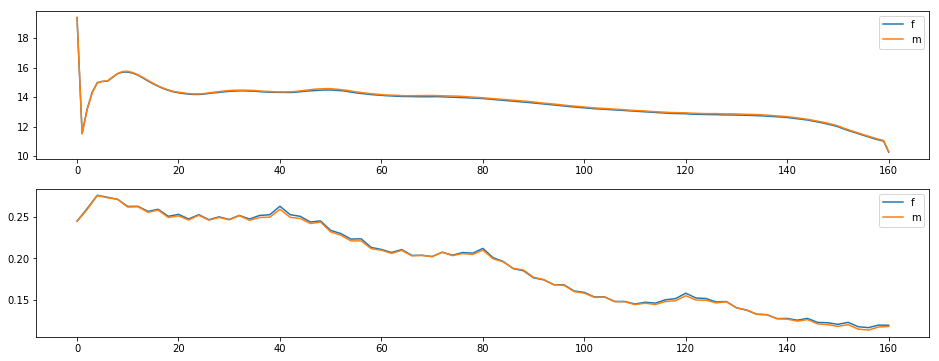

In [49]:
plt.figure(figsize=(16, 6))

ax = plt.subplot(2, 1, 1)
ax.plot(train_input_f)
ax.plot(train_input_m)
ax.legend(['f', 'm'])

ax = plt.subplot(2, 1, 2)
ax.plot(grad_input_f)
ax.plot(grad_input_m)
ax.legend(['f', 'm'])


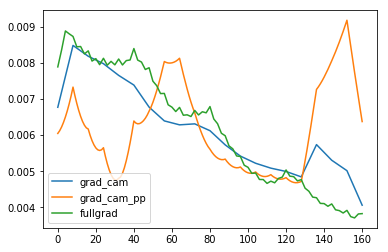

In [54]:
for cam_method in ["grad_cam", "grad_cam_pp", "fullgrad"]:
    weight_path='/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/gradient/LoResNet8/vox2/klsp_egs_baseline/arcsoft/Mean_cbam_None_dp01_alpha0_em256_var/epoch_61_var_%s/epoch_61' % cam_method
    with open(weight_path + '/freq.data.pickle', 'rb') as f:
        freq_weight = pickle.load(f)
    this_weight = freq_weight['train.time.mean']
    plt.plot(this_weight/this_weight.sum())
plt.legend(["grad_cam", "grad_cam_pp", "fullgrad"])
  

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


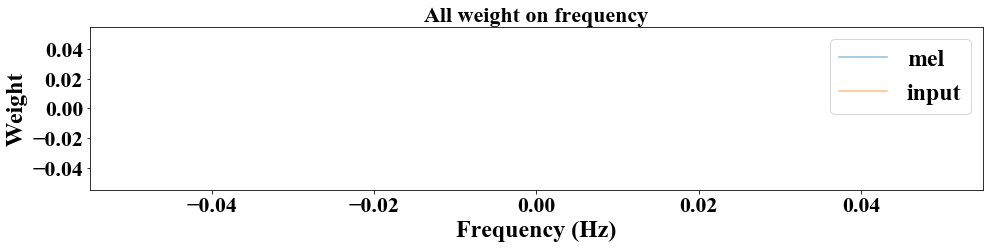

In [25]:
# all_data [5, 2, 120, 161]
# plotting filters distributions

# train_data [numofutt, feats[N, 161]]
train_input = freq_data['train.data.mean']
valid_input = freq_data['valid.data.mean']
train_grad = freq_data['train.time.mean']
train_grad_part = freq_data['train.time.mean.part']
print(train_grad)
valid_grad = freq_data['valid.time.mean']

x = np.arange(feat_dim) * 8000 / (feat_dim - 1)  # [0-8000]
if acoustic_feature == 'fbank':
    m = np.linspace(0, 2840.0230467083188, feat_dim)
    x = mel2hz(m)

# y = np.sum(all_data, axis=2)  # [5, 2, 162]
plt.rc('font', family='Times New Roman')

plt.figure(figsize=(16, 3))
# plt.title('Gradient Distributions', fontsize=22)
plt.title('All weight on frequency', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel('Weight', fontsize=24)
plt.yticks(fontsize=22)

m = np.arange(0, 2840.0230467083188)
m = 700 * (10 ** (m / 2595.0) - 1)
n = np.array([m[i] - m[i - 1] for i in range(1, len(m))])
n = 1 / n

f = interpolate.interp1d(m[1:], n)
xnew = np.arange(np.min(m[1:]), np.max(m[1:]), (np.max(m[1:]) - np.min(m[1:])) / 161)
ynew = f(xnew)
ynew = ynew / ynew.sum()#.max()
# plt.plot(xnew, ynew)
# print(np.sum(ynew))

# for s in train_grad, valid_grad, veri_grad, veri_grad_relu, test_grad:
# for s in veri_grad, veri_grad_relu:
# for s in train_grad, veri_grad, test_grad:
# for s in (np.abs(train_grad),train_grad_part) :
for s in (train_grad_part, train_grad) :


    # for s in test_a_set_grad, test_b_set_grad:
    f = interpolate.interp1d(x, s)
    xnew = np.linspace(np.min(x), np.max(x), 161)
    ynew = f(xnew)
    ynew = ynew / ynew.sum() #.max()
    plt.plot(xnew, ynew, alpha=0.5)
    # pdb.set_trace
# if not os.path.exists(args.extract_path + '/grad.npy'):
ynew = train_grad
ynew = ynew / ynew.sum()

# np.save(extract_path + '/train.grad.veri.npy', veri_grad)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Test_a', 'Test_b'], loc='upper right', fontsize=18)
# plt.legend(['Train', 'Valid', 'Train Verify', 'Train Verify Relu', 'Test'], loc='upper right', fontsize=24)
plt.legend(['mel', 'input','Train', 'Train Verify', 'Test'], loc='upper right', fontsize=24)

# plt.legend(['input', 'Train Verify', 'Train Verify Relu'], loc='upper right', fontsize=24)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Train Verify', 'Test'], loc='upper right', fontsize=24)
# pdf.savefig()
# pdf.close()

# plt.savefig(args.extract_path + "/grads.png")
plt.show()

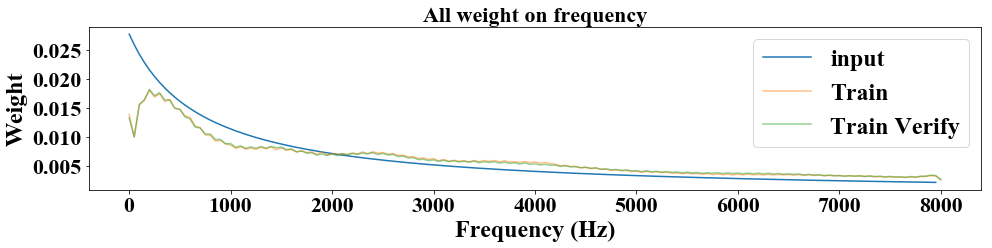

In [22]:
# all_data [5, 2, 120, 161]
# plotting filters distributions

# train_data [numofutt, feats[N, 161]]
train_input = freq_data['train.data.mean']
valid_input = freq_data['valid.data.mean']
test_input = freq_data['test.veri.data.mean']

train_grad = freq_data['train.time.mean']
train_grad_part = freq_data['train.time.mean.part']

valid_grad = freq_data['valid.time.mean']
veri_grad = freq_data['train.veri.time.mean']
veri_grad_relu = freq_data['train.veri.time.relu']

te3t_grad = freq_data['test.veri.time.mean']
test_grad_relu = freq_data['test.veri.time.relu']

x = np.arange(feat_dim) * 8000 / (feat_dim - 1)  # [0-8000]
if acoustic_feature == 'fbank':
    m = np.linspace(0, 2840.0230467083188, feat_dim)
    x = mel2hz(m)

# y = np.sum(all_data, axis=2)  # [5, 2, 162]
plt.rc('font', family='Times New Roman')

plt.figure(figsize=(16, 3))
# plt.title('Gradient Distributions', fontsize=22)
plt.title('All weight on frequency', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel('Weight', fontsize=24)
plt.yticks(fontsize=22)

m = np.arange(0, 2840.0230467083188)
m = 700 * (10 ** (m / 2595.0) - 1)
n = np.array([m[i] - m[i - 1] for i in range(1, len(m))])
n = 1 / n

f = interpolate.interp1d(m[1:], n)
xnew = np.arange(np.min(m[1:]), np.max(m[1:]), (np.max(m[1:]) - np.min(m[1:])) / 161)
ynew = f(xnew)
ynew = ynew / ynew.sum()#.max()
plt.plot(xnew, ynew)
# print(np.sum(ynew))

# for s in train_grad, valid_grad, veri_grad, veri_grad_relu, test_grad:
# for s in veri_grad, veri_grad_relu:
# for s in train_grad, veri_grad, test_grad:
# for s in (np.abs(train_grad),train_grad_part) :
for s in (train_grad_part, veri_grad) :


    # for s in test_a_set_grad, test_b_set_grad:
    f = interpolate.interp1d(x, s)
    xnew = np.linspace(np.min(x), np.max(x), 161)
    ynew = f(xnew)
    ynew = ynew / ynew.sum() #.max()
    plt.plot(xnew, ynew, alpha=0.5)
    # pdb.set_trace
# if not os.path.exists(args.extract_path + '/grad.npy'):
ynew = veri_grad
ynew = ynew / ynew.sum()

np.save(extract_path + '/train.grad.veri.npy', veri_grad)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Test_a', 'Test_b'], loc='upper right', fontsize=18)
# plt.legend(['Train', 'Valid', 'Train Verify', 'Train Verify Relu', 'Test'], loc='upper right', fontsize=24)
plt.legend(['input','Train', 'Train Verify', 'Test'], loc='upper right', fontsize=24)

# plt.legend(['input', 'Train Verify', 'Train Verify Relu'], loc='upper right', fontsize=24)

# plt.legend(['Mel-scale', 'Train', 'Valid', 'Train Verify', 'Test'], loc='upper right', fontsize=24)
# pdf.savefig()
# pdf.close()

# plt.savefig(args.extract_path + "/grads.png")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Data distributions', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Log Power (-)', fontsize=16)
# 插值平滑 ？？？
for s in train_input, valid_input, test_input:
    # for s in test_a_set_grad, test_b_set_grad:
    f = interpolate.interp1d(x, s)
    xnew = np.linspace(np.min(x), np.max(x), 161)
    ynew = f(xnew)
    plt.plot(xnew, ynew)

plt.legend(['Train', 'Valid', 'Test'], loc='upper right', fontsize=16)
# plt.savefig(args.extract_path + "/inputs.freq.png")
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Data distributions in Time Axis', fontsize=22)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Magnetitude', fontsize=16)
# 插值平滑 ？？？
# for i, (data, grad) in enumerate(time_data):
# for s in test_a_set_grad, test_b_set_grad:
data = time_data[0][0]
grad = time_data[0][1]
norm = matplotlib.colors.Normalize(vmin=0., vmax=1.)
# data_mean = data.mean(axis=10

ax = plt.subplot(2, 1, 1)

# data = (data - data.min()) / (data.max() - data.min())
# im = ax.imshow(np.log(data.transpose()), cmap='viridis', aspect='auto')
im = ax.imshow(data.transpose(), cmap='viridis', aspect='auto')
# print(data.min(), data.max())
plt.colorbar(im)  # 显示颜色标尺
# ax.plot(data_mean)

ax = plt.subplot(2, 1, 2)
grad = np.abs(grad)
grad_mean = grad
# grad_mean = (grad - grad.min()) / (grad.max() - grad.min())
# im = ax.imshow(1/np.log(grad_mean.transpose()), norm=norm, cmap='viridis', aspect='auto')
im = ax.imshow(grad_mean.transpose(), cmap='viridis', aspect='auto')
# ax.plot(np.log(grad_mean))
ax.set_xlim(0, len(grad_mean))

# plt.legend(['Train', 'Valid', 'Test'], loc='upper right', fontsize=16)
plt.colorbar(im)  # 显示颜色标尺
# plt.savefig(args.extract_path + "/inputs.time.png")
plt.show()

print('Completed!\n')